Buscando artefatos no caminho real: /Users/tiagoribeiro/PycharmProjects/5mlet-fase5-final/app/model
Iniciando bateria de testes...

Treinando modelo com 100 árvores...


2026-02-21 14:27:55,372 INFO data_loaded
2026-02-21 14:27:57,631 INFO data_loaded
2026-02-21 14:27:58,518 INFO training_complete


Treinando modelo com 200 árvores...


2026-02-21 14:28:06,780 INFO data_loaded
2026-02-21 14:28:13,303 INFO data_loaded
2026-02-21 14:28:15,684 INFO training_complete


Treinando modelo com 400 árvores...


2026-02-21 14:28:23,508 INFO data_loaded
2026-02-21 14:28:24,928 INFO data_loaded
2026-02-21 14:28:27,283 INFO training_complete


Treinando modelo com 600 árvores...


2026-02-21 14:28:33,441 INFO data_loaded
2026-02-21 14:28:34,972 INFO data_loaded
2026-02-21 14:28:38,516 INFO training_complete


,trees,auc,recall,f1
0,100,0.718474,0.571429,0.640000
1,200,0.705467,0.559524,0.630872
2,400,0.728395,0.571429,0.640000
3,600,0.727513,0.571429,0.644295


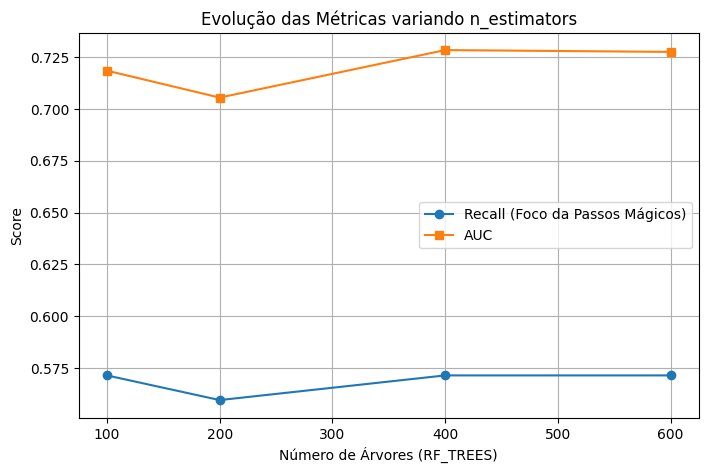

In [10]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path

# 0. Garante que o notebook consiga importar o src
sys.path.append(os.path.abspath(".."))
from src.utils import ARTIFACT_DIR

# --- A CORREÇÃO DE TECH LEAD ---
# Descobre o caminho absoluto da raiz do projeto
PROJECT_ROOT = Path("..").resolve()
# -------------------------------

# 1. Definimos o grid de parâmetros que queremos testar
n_trees_options = [100, 200, 400, 600]
resultados = []

print(f"Buscando artefatos no caminho real: {PROJECT_ROOT / ARTIFACT_DIR}")
print("Iniciando bateria de testes...\n")

for trees in n_trees_options:
    # 2. Injetamos o parâmetro na variável de ambiente esperada pelo seu train.py
    os.environ["RF_TREES"] = str(trees)

    # Nomeamos a versão do modelo para tracking
    model_version = f"rf_trees_{trees}"

    # 3. Executamos o SEU script de produção como um MÓDULO (-m)
    print(f"Treinando modelo com {trees} árvores...")
    comando = f"python -m src.train --model-version {model_version}"
    subprocess.run(comando, shell=True, check=True, cwd=str(PROJECT_ROOT))

    # 4. Lemos o metadata.json usando a raiz absoluta
    artifact_path = PROJECT_ROOT / ARTIFACT_DIR / "metadata.json"

    try:
        with open(artifact_path, "r", encoding="utf-8") as f:
            metadata = json.load(f)

        # Extraímos as métricas e guardamos na nossa lista
        metrics = metadata["metrics"]
        resultados.append({
            "trees": trees,
            "auc": metrics["auc"],
            "recall": metrics["recall"],
            "f1": metrics["f1"]
        })
    except FileNotFoundError:
        print(f"Erro: Artefato não encontrado em {artifact_path}.")

# 5. Transformamos em DataFrame para avaliar e plotar
if resultados:
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados)

    # Plotando a curva de validação
    plt.figure(figsize=(8, 5))
    plt.plot(df_resultados['trees'], df_resultados['recall'], marker='o', label='Recall (Foco da Passos Mágicos)')
    plt.plot(df_resultados['trees'], df_resultados['auc'], marker='s', label='AUC')
    plt.title('Evolução das Métricas variando n_estimators')
    plt.xlabel('Número de Árvores (RF_TREES)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Nenhum resultado foi coletado.")

--- Otimização de Ponto de Corte (Threshold Tuning) ---


2026-02-21 14:34:24,819 INFO data_loaded
2026-02-21 14:34:30,194 INFO data_loaded



Resultados do Threshold Tuning:
Corte: 0.50 | Recall: 0.571
Corte: 0.45 | Recall: 0.940
Corte: 0.40 | Recall: 0.964
Corte: 0.35 | Recall: 0.976
Corte: 0.30 | Recall: 0.988


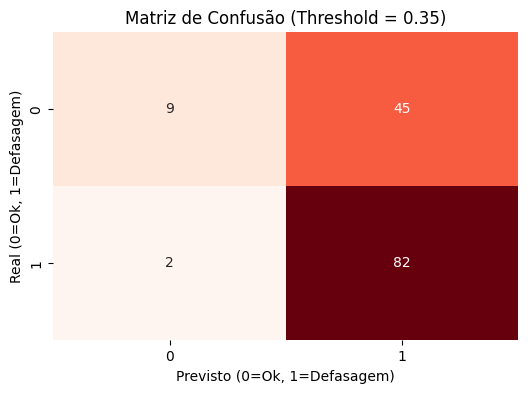

In [14]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import seaborn as sns
from sklearn.model_selection import train_test_split

print("--- Otimização de Ponto de Corte (Threshold Tuning) ---")

# 1. Carregamos o melhor modelo salvo pelo seu pipeline
modelo_path = PROJECT_ROOT / ARTIFACT_DIR / "model.joblib"
melhor_modelo = joblib.load(modelo_path)

# 2. Carregamos e preparamos os dados
from src.data_loader import load_all_training_data
from src.preprocessing import split_X_y
from src.feature_engineering import add_derived_features

df = load_all_training_data(PROJECT_ROOT / "data")
X, y = split_X_y(df)
X = add_derived_features(X)

# --- REPLICANDO O SCHEMA ENFORCEMENT DO TRAIN.PY ---
categorical = ["FASE_TURMA", "PEDRA", "INSTITUICAO"]
categorical = [c for c in categorical if c in X.columns]
numeric = [c for c in X.columns if c not in categorical]

for col in numeric:
    if X[col].dtype == "object" or X[col].dtype.name == "string":
        X[col] = X[col].astype(str).str.replace(',', '.', regex=False)
    X[col] = pd.to_numeric(X[col], errors="coerce")

for col in categorical:
    X[col] = X[col].astype(str)
# ---------------------------------------------------

# 3. Garantindo o mesmo split do seu train.py
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Em vez de predict(), usamos predict_proba()!
probabilidades = melhor_modelo.predict_proba(X_val)[:, 1] # Pega a probabilidade da classe 1 (Defasagem)

# 5. Testamos diferentes pontos de corte
cortes = [0.50, 0.45, 0.40, 0.35, 0.30]

print("\nResultados do Threshold Tuning:")
for corte in cortes:
    predicoes_ajustadas = (probabilidades >= corte).astype(int)
    recall_atual = recall_score(y_val, predicoes_ajustadas)
    print(f"Corte: {corte:.2f} | Recall: {recall_atual:.3f}")

# 6. Visualizando a Matriz de Confusão do melhor corte (ex: 0.35)
melhor_corte = 0.35
predicoes_finais = (probabilidades >= melhor_corte).astype(int)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, predicoes_finais), annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Matriz de Confusão (Threshold = {melhor_corte})')
plt.xlabel('Previsto (0=Ok, 1=Defasagem)')
plt.ylabel('Real (0=Ok, 1=Defasagem)')
plt.show()